<a href="https://colab.research.google.com/github/doodger/dataScience/blob/development/finance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Under construction
This project seeks to compare historical American demographic trends and S&P 500 trends. Later on, Japanese demographic trends and Nikkei 225 trends are added to the data to augment it. As a training exercise, the entire chain of things I added was maintained, to help gauge my progress.

In [1]:
#General Imports
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression,Ridge,Lasso,LassoCV,ElasticNet
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
!pip install xgboost
from xgboost import XGBRegressor #creates annoying warnings
from tqdm import tqdm


#import warnings  #code to supress warnings; dangerous; useful for xgboost module
#warnings.filterwarnings("ignore")


In [2]:
#Data imports USA
populationURL = "https://raw.githubusercontent.com/doodger/dataScience/master/38f6e261-94a4-4bdf-b5db-5d75022e46bb_Data.csv"
SaP500URL = "https://raw.githubusercontent.com/doodger/dataScience/master/%5EGSPC.csv"

pop_df = pd.read_csv(populationURL)
sap_df = pd.read_csv(SaP500URL)

##Data cleaning and sorting for the population

#Demographics data
pop_df.head()
#Rows 35,36 and 37 are rows of Nan
#Rows 38 and 39 only have a value at the head, detailling the database's World bank origin

print("Total missing value for rows 0 to 34:",pop_df.loc[0:34].isnull().sum().sum())
pop_df = pop_df.loc[0:34]

#With the un-needed rows cut off, the dataframe can be reordered so that the rows of population groups
#    are in chronological order
pop_df = pop_df.sort_values("Series Code")
#Row 21 is superfluous (65+ women), and can be deleted. The index are then labeled to a proper order
pop_df = pop_df.drop([21])
pop_df.index= [i for i in range(34)]
#The 17 age groups are now in ascending order for both women and men

Total missing value for rows 0 to 34: 0


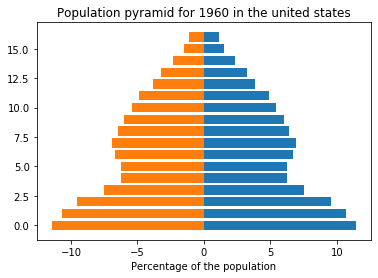

In [3]:
##Visualization

#Sample age pyramid for 1960
yMen = [pop_df.loc[i,"1960 [YR1960]"] for i in range(1,34,2)]
yWomen = [-pop_df.loc[i,"1960 [YR1960]"] for i in range(1,34,2)]
#Here the women's number will be in the negative by convention


x = [i for i in range(17)]
ax = plt.subplot(111)
ax.barh(x,yMen)
ax.barh(x,yWomen)
plt.xlabel("Percentage of the population")
ax.set_title("Population pyramid for 1960 in the united states")
plt.show()


Total missing value for S&P data: 0


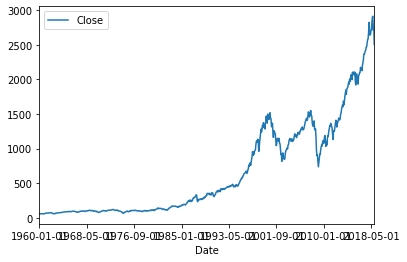

In [4]:
#Financial data

#S&P 500 data
sap_df.head()
print("Total missing value for S&P data:",sap_df.isnull().sum().sum())
#The population data only extends to 2018, and so the 2019 data of the S&P can be cut
#2019 data is from row 708 onward
sap_df = sap_df.loc[0:707]

#History of the S&P500 
sap_df.plot.line(x="Date",y="Close")

## Creating a joint dataset
#Turning the monthly stock market data into annualized data to compare it with the population will be helpful
#To do this a set of yearly statistics for the S&P data will be calculated and afterward both dataframes will be merged into one consolidated dataframe


colAvgClose = [0]*59
colYear = [0]*59
colVolatility = [0]*59
colVolume = [0]*59
colYearlyPercentageVariation = [0]*59
#populating each of the 59 years
for i in range(59):
  colAvgClose[i] = sap_df.loc[i:i+11,"Close"].mean() #yearly mean of closing price
  colVolatility[i] = sap_df.loc[i:i+11,"Close"].std() #experiment to get the volatility in percentage
  colVolume[i] = sap_df.loc[i:i+11,"Close"].mean()

for i in range(1,59):#1960 has no previous year data and thus no percentage variation for now
  colYearlyPercentageVariation[i] = 100*(colAvgClose[i]-colAvgClose[i-1])/colAvgClose[i-1]

#Columns from the S&P set

columns = []
columns.append( ("year", [1960 + i for i in range(59)]) )
columns.append( ("avgClose", colAvgClose) )
columns.append( ("volatility", colVolatility) )
columns.append( ("volume", colVolume) )
columns.append( ("yearPctVar", colYearlyPercentageVariation))
#Columns from the pop set
pop_columns = ["0t4F","0t4M","5t9F","5t9M","10t14F","10t14M","15t19F","15t19M",
               "20t24F","20t24M","25t29F","25t29M","30t34F", "30t34M","35t39F",
                "35t39M","40t44F", "40t44M","45t49F","45t49M",
           "50t54F","50t54M","55t59F","55t59M","60t64F", "60t64M","65t69F","65t69M",
           "70t74F","70t74M",
           "75t79F","75t79M","80pF","80pM"]
for i in range(34):
  columns.append( (pop_columns[i], pd.to_numeric(pop_df.loc[i,"1960 [YR1960]":"2018 [YR2018]"]) ) ) #columns were being copied as object instead of numeric

#creating the joint dataframe
merged_df = pd.DataFrame(dict(columns))
merged_df.index = [i for i in range(59)] #To get rid of inherited index names from pop_df


## Exploratory data analysis
Ideas:

*  Volume?
*  Price increase?
*  Correlation between upward/downward mobility and # of youth/old



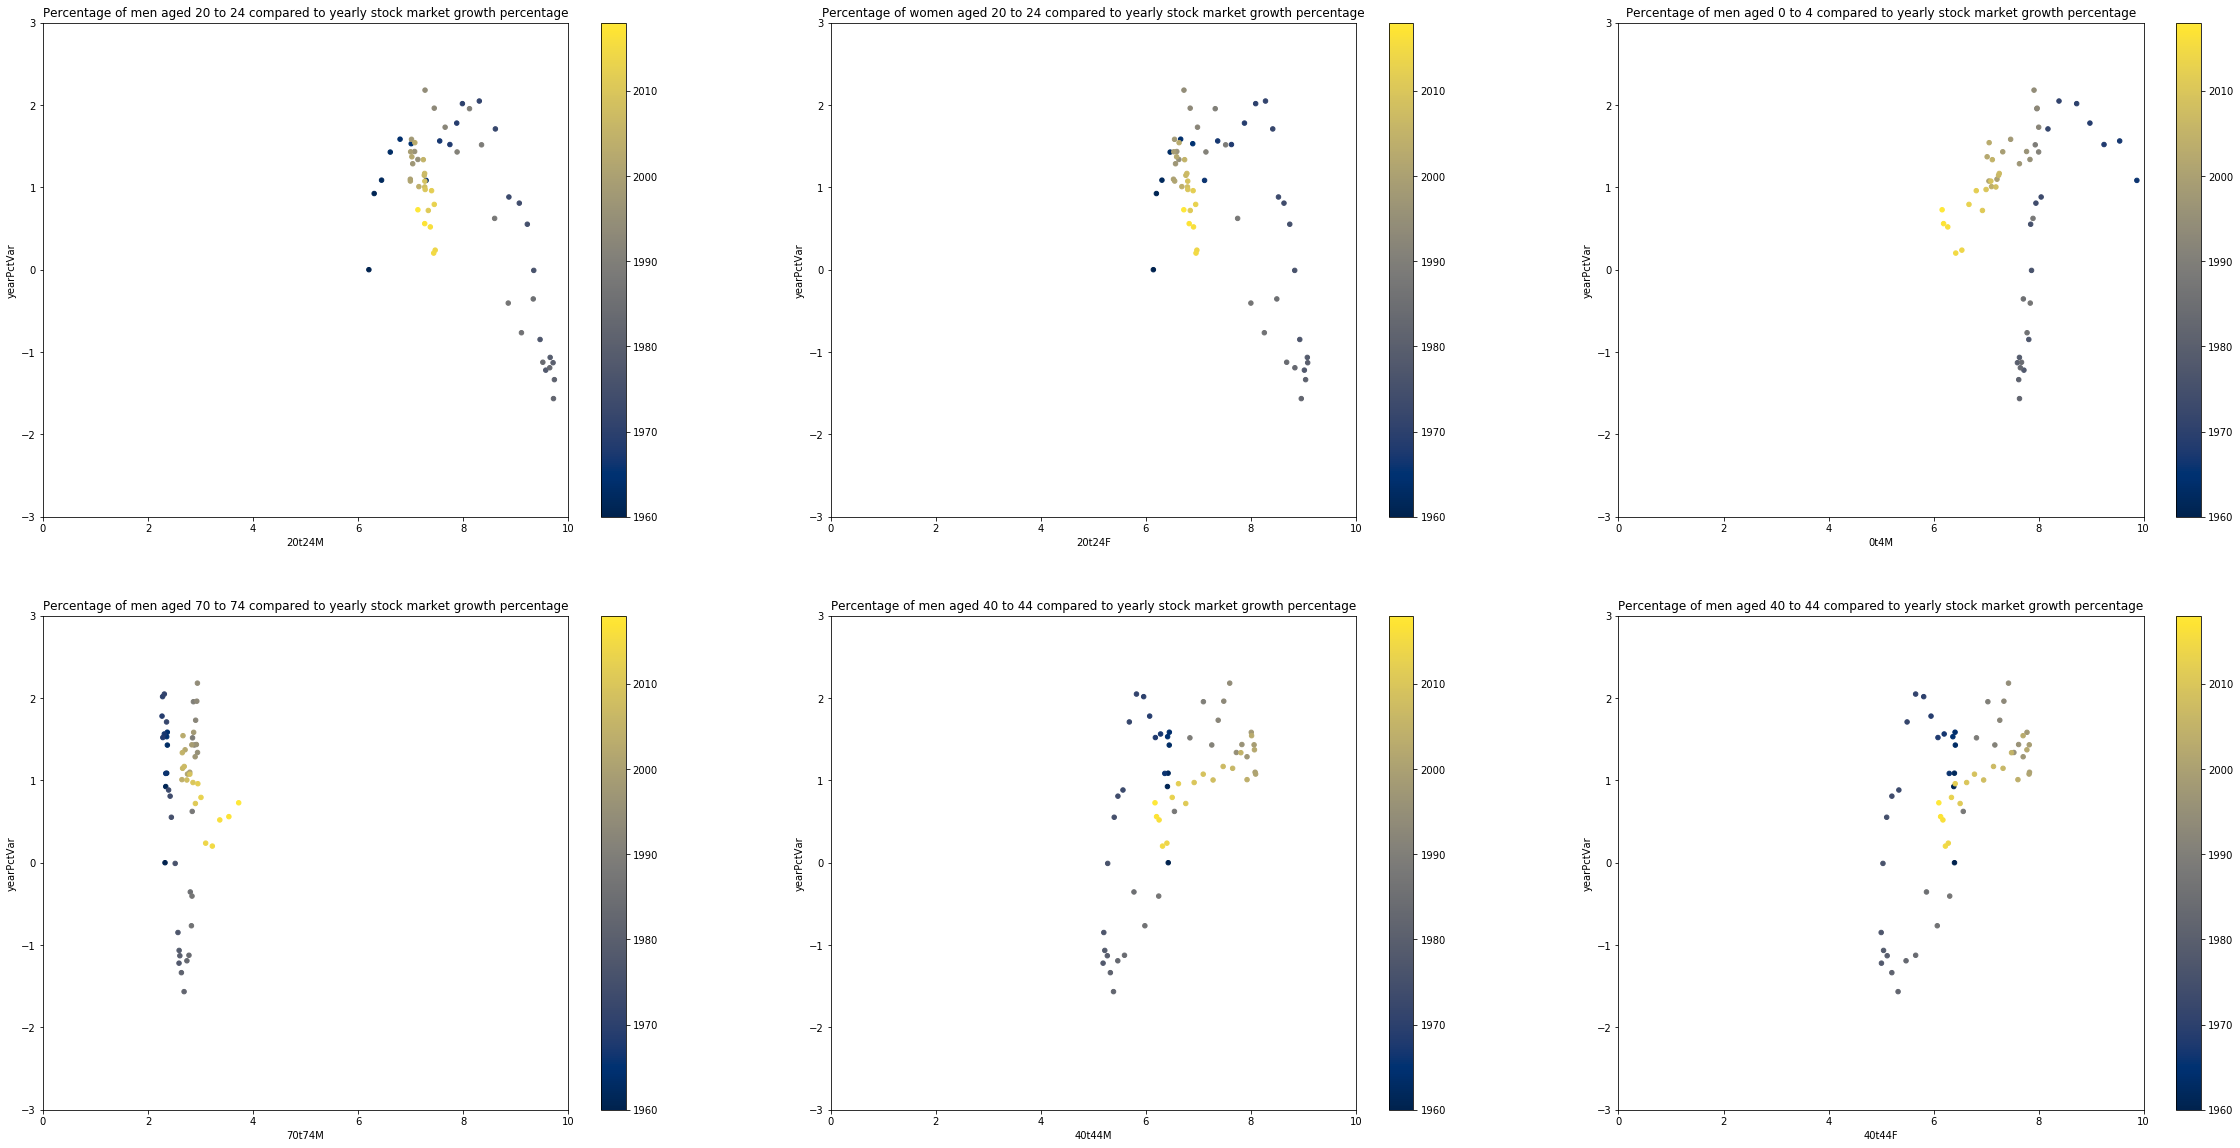

In [5]:
#A few scatter plots of demographic group versus the yearly growth
fig, axes = plt.subplots(ncols=3, nrows=2,figsize=(40,20))
plt.setp(axes, xlim=(0,10),ylim=(-3,3))
merged_df.plot.scatter(ax=axes[0,0],x="20t24M", y="yearPctVar",c=[i for i in range(1960,2019)],cmap="cividis",title = "Percentage of men aged 20 to 24 compared to yearly stock market growth percentage")#young men vs %-variation
merged_df.plot.scatter(ax=axes[0,1],x="20t24F", y="yearPctVar",c=[i for i in range(1960,2019)],cmap="cividis",title = "Percentage of women aged 20 to 24 compared to yearly stock market growth percentage")#young women vs %-variation
merged_df.plot.scatter(ax=axes[0,2],x="0t4M", y="yearPctVar",c=[i for i in range(1960,2019)],cmap="cividis",title = "Percentage of men aged 0 to 4 compared to yearly stock market growth percentage")#male babies vs %-variation
merged_df.plot.scatter(ax=axes[1,0],x="70t74M", y="yearPctVar",c=[i for i in range(1960,2019)],cmap="cividis",title = "Percentage of men aged 70 to 74 compared to yearly stock market growth percentage")#male retirees vs %-variation
merged_df.plot.scatter(ax=axes[1,1],x="40t44M", y="yearPctVar",c=[i for i in range(1960,2019)],cmap="cividis",title = "Percentage of men aged 40 to 44 compared to yearly stock market growth percentage")#male midlife vs %-variation
merged_df.plot.scatter(ax=axes[1,2],x="40t44F", y="yearPctVar",c=[i for i in range(1960,2019)],cmap="cividis",title = "Percentage of men aged 40 to 44 compared to yearly stock market growth percentage")#male retirees vs %-variation  

In [6]:
corrMatrix = merged_df.corr() #correlation matrix of the merged df
corrMatrix.style.background_gradient(cmap='PiYG', axis=None)

Observation and curious things:



*   Strong correlation of people in their 40s with stock market? Perhaps people are starting to invest for their retirement?
*   Strong negative corellation for people in their 20s with stock market... Perhaps young adults are less likely to invest?
*   Smaller correlation between kids/pre-teens and stock market... Perhaps only tracking that if there's a lot of kids there's probably a lot of adults investing?
*   Financial data is not adjusted to population growth, so it's not surprising that as time goes on and more and more people are alive in the US the volume of trading goes up (among other factors)
*   Volatility of standardized data didn't seem to change much so it was not kept for the time being




Explained % of variance for 2 component PCA: 0.7500213974671512
Explained % of variance for 3 component PCA: 0.9376381886183611


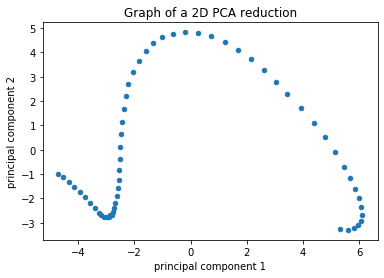

In [7]:
X = merged_df.loc[:,"0t4F":"80pM"] #Don't scale it since the data might not be Gaussian and already same scale?
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalX_df = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
principalX_df.plot.scatter('principal component 1', 'principal component 2',title="Graph of a 2D PCA reduction")
print("Explained % of variance for 2 component PCA:",sum(pca.explained_variance_ratio_))

pca = PCA(n_components=3)
principalComponents = pca.fit_transform(X)
principalX_df = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
principalX_df
print("Explained % of variance for 3 component PCA:",sum(pca.explained_variance_ratio_))


Text(1, 2.7, 'MSE:0.36821032480305954')

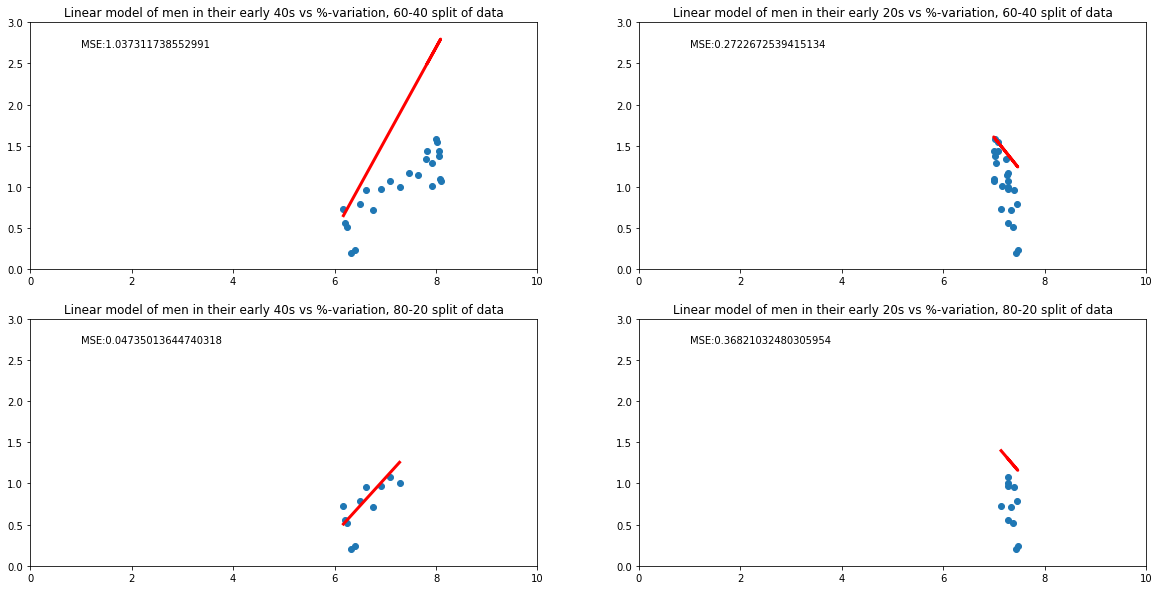

In [8]:
## Model testing


#Just a few linear regressions to begin with?
#A roughly 60-40 split in training and validation is taken
X_train = merged_df.loc[0:35,"0t4F":"80pM"] 
X_test = merged_df.loc[36:,"0t4F":"80pM"]
#The target will be the yearly percent change in value
y_train = merged_df.loc[0:35,"yearPctVar"]
y_test = merged_df.loc[36:,"yearPctVar"]

#Simple model where only men of 40 to 44 is used
mod1 = LinearRegression()
mod1.fit(X_train[["40t44M"]],y_train)
result1 = mod1.predict(X_test[["40t44M"]])

#Simple model where men of 20 to 24 is used to predict prices
mod2 = LinearRegression()
mod2.fit(X_train[["20t24M"]],y_train)
result2 = mod2.predict(X_test[["20t24M"]])




#A roughly 80-20 split in training and validation is taken
X_train2 = merged_df.loc[0:47,"0t4F":"80pM"] 
X_test2 = merged_df.loc[48:,"0t4F":"80pM"]
#The target will be the yearly percent change in value
y_train2 = merged_df.loc[0:47,"yearPctVar"]
y_test2 = merged_df.loc[48:,"yearPctVar"]

#Simple model where only men of 40 to 44 is used
mod3 = LinearRegression()
mod3.fit(X_train2[["40t44M"]],y_train2)
result3 = mod3.predict(X_test2[["40t44M"]])

#Simple model where men of 20 to 24 is used to predict prices
mod4 = LinearRegression()
mod4.fit(X_train2[["20t24M"]],y_train2)
result4 = mod4.predict(X_test2[["20t24M"]])

#plots
fig, axes = plt.subplots(ncols=2, nrows=2,figsize=(20,10))
plt.setp(axes, xlim=(0,10),ylim=(0,3))

axes[0,0].title.set_text("Linear model of men in their early 40s vs %-variation, 60-40 split of data")
axes[0,0].scatter(x=X_test[["40t44M"]], y=y_test)#old men vs %-variation
axes[0,0].plot(X_test[["40t44M"]],result1, color='red', linewidth=3)
axes[0,0].text(1,2.7,"MSE:"+str(mean_squared_error(y_test,result1)))

axes[0,1].title.set_text("Linear model of men in their early 20s vs %-variation, 60-40 split of data")
axes[0,1].scatter(x=X_test[["20t24M"]], y=y_test)#young men vs %-variation
axes[0,1].plot(X_test[["20t24M"]],result2, color='red', linewidth=3)
axes[0,1].text(1,2.7,"MSE:"+str(mean_squared_error(y_test,result2)))

axes[1,0].title.set_text("Linear model of men in their early 40s vs %-variation, 80-20 split of data")
axes[1,0].scatter(x=X_test2[["40t44M"]], y=y_test2)#old men vs %-variation
axes[1,0].plot(X_test2[["40t44M"]],result3, color='red', linewidth=3)
axes[1,0].text(1,2.7,"MSE:"+str(mean_squared_error(y_test2,result3)))

axes[1,1].title.set_text("Linear model of men in their early 20s vs %-variation, 80-20 split of data")
axes[1,1].scatter(x=X_test2[["20t24M"]], y=y_test2)#old men vs %-variation
axes[1,1].plot(X_test2[["20t24M"]],result4, color='red', linewidth=3)
axes[1,1].text(1,2.7,"MSE:"+str(mean_squared_error(y_test2,result4)))


In [0]:
#More model testing, this time a set of models

#Full data, useful for CV methods
X = merged_df.loc[:,"0t4F":"80pM"] 
y = merged_df.loc[:,"yearPctVar"]


#the 80-20 split is retained for the first round of testing
EightyTwenty_X_train = X_train2
EightyTwenty_X_test = X_test2
EightyTwenty_y_train = y_train2
EightyTwenty_y_test = y_test2

def testSetOfModels(X_train = EightyTwenty_X_train, y_train = EightyTwenty_y_train, X_test = EightyTwenty_X_test, y_test = EightyTwenty_y_test, performanceMetric = mean_squared_error, verbose = True):
  #This function aims to test a range of models on various sets of training/test data
  # as well as on many different metrics

  #The verbose parameter outputs the performance of every model as a print

  #By default it uses the 80-20 split data and MSE as a performance metric, and is verbose
  #The verbose

  
  outputPerformance = []

  model1 = LinearRegression()
  model1.fit(X_train,y_train)
  y_pred1 = model1.predict(X_test)
  outputPerformance.append(performanceMetric(y_test,y_pred1))
  if verbose == True : print("Linear regression performance using ", str(performanceMetric), ":", performanceMetric(y_test,y_pred1))
  #print("Coefficients for Linear Regression:",model1.coef_)

  model2 = ElasticNet() #Using the ElasticNet regularization method
  model2.fit(X_train,y_train)
  y_pred2 = model2.predict(X_test)
  outputPerformance.append(performanceMetric(y_test,y_pred2))
  if verbose == True : print("Elastic net performance using ", str(performanceMetric), ":",outputPerformance[-1])
  #print("Coefficients for Elastic Net:",model2.coef_)


  model3 = Lasso() #Using the Lasso (Or L1 norm)
  model3.fit(X_train,y_train)
  y_pred3 = model3.predict(X_test)
  outputPerformance.append(performanceMetric(y_test,y_pred3))
  if verbose == True : print("Lasso performance using ", str(performanceMetric), ":",outputPerformance[-1])
  #print("Coefficients for Lasso:",model3.coef_)


  model4 = DecisionTreeRegressor(max_depth = 2) #2 depth decision tree
  model4.fit(X_train,y_train)
  y_pred4 = model4.predict(X_test)
  outputPerformance.append(performanceMetric(y_test,y_pred4))
  if verbose == True : print("2 Depth Decision tree performance using ", str(performanceMetric), ":",outputPerformance[-1])

  model5 = DecisionTreeRegressor(max_depth = 5) #5 depth decision tree
  #MSE varies between being better and worse than 2 depth, this deserves a crossvalidation grid search probably TODO
  model5.fit(X_train,y_train)
  y_pred5 = model5.predict(X_test)
  outputPerformance.append(performanceMetric(y_test,y_pred5))
  if verbose == True : print("5 Depth Decision tree performance using ", str(performanceMetric), ":",outputPerformance[-1]) #MSE varies between being better and worse than 2 depth, this deserves a crossvalidation grid search probably TODO

  model6 = MLPRegressor(hidden_layer_sizes = 50, max_iter = 1000) #Standard multilayer perceptron, with 30x1 Layers x depth
  #Very irregular performance; can be good or awful compared to lasso benchmark
  model6.fit(X_train,y_train)
  y_pred6 = model6.predict(X_test)
  outputPerformance.append(performanceMetric(y_test,y_pred6))
  if verbose == True : print("50 layers Perceptron Regressor performance using ", str(performanceMetric), ":",outputPerformance[-1]) #MSE varies between being better and worse than 2 depth, this deserves a crossvalidation grid search probably TODO

  model7 = RandomForestRegressor(n_estimators=12) #After testing, a number of 12 trees was decided (p/3)
  model7.fit(X_train,y_train)
  y_pred7 = model7.predict(X_test)
  outputPerformance.append(performanceMetric(y_test,y_pred7))
  if verbose == True : print("Default Random Forest performance using ", str(performanceMetric), ":", outputPerformance[-1])

  model8 = GradientBoostingRegressor() #Standard gradient boosting
  model8.fit(X_train,y_train)
  y_pred8 = model8.predict(X_test)
  outputPerformance.append(performanceMetric(y_test,y_pred8))
  if verbose == True : print("Default Gradient Boosting performance using ", str(performanceMetric), ":", outputPerformance[-1])

  model9 = XGBRegressor()
  #After investigation, earlier underperformance was caused by massive overfitting. A stopping parameter has thus been added.
  model9.fit(X_train,y_train, early_stopping_rounds = 10, eval_set = [(X_test,y_test)], eval_metric = "rmse", verbose = False)
  y_pred9 = model9.predict(X_test)
  outputPerformance.append(performanceMetric(y_test,y_pred9))
  if verbose == True : print("Default XGBoost performance using ", str(performanceMetric), ":", outputPerformance[-1])
  
  return(outputPerformance)



/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[20:12:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:12:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[20:12:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[20:12:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[20:12:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:12:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[20:12:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[20:12:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:12:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[20:12:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:12:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[20:12:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[20:12:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:12:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[20:12:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:12:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[20:12:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[20:12:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:12:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:12:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Text(0, 0.5, 'Log 10-MSE')

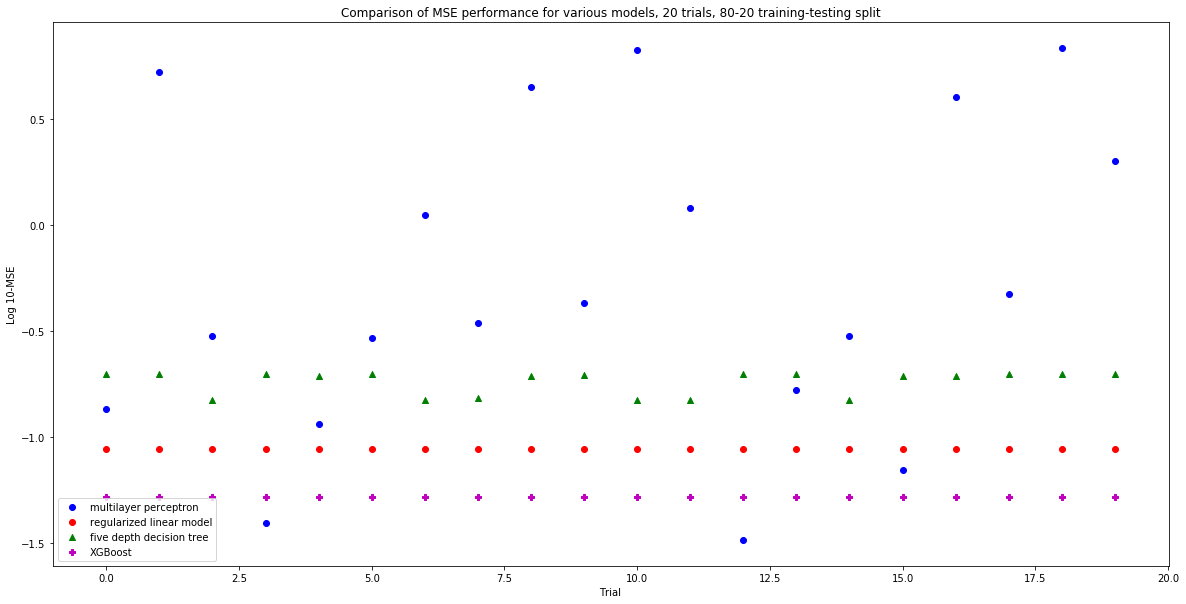

In [10]:
testPoints = []
for i in range (20):
  testPoints.append(testSetOfModels(verbose = False))
fig, axes = plt.subplots(ncols=1, nrows=1,figsize=(20,10))

axes.title.set_text("Comparison of MSE performance for various models, 20 trials, 80-20 training-testing split")
plt.scatter([i for i in range(20)], [np.log10(j[5]) for j in testPoints], c='b', label="multilayer perceptron")
plt.scatter([i for i in range(20)], [np.log10(j[2]) for j in testPoints], c='r', label="regularized linear model")
plt.scatter([i for i in range(20)], [np.log10(j[4]) for j in testPoints], c='g', marker = "^", label="five depth decision tree")
plt.scatter([i for i in range(20)], [np.log10(j[8]) for j in testPoints], c='m', marker = "P", label="XGBoost")
axes.legend()
plt.xlabel("Trial")
plt.ylabel("Log 10-MSE")


A first run of performance tests using 1960 to 2007 (a 80-20 training-test split) shows a few interesting models:


*   A regularized linear regressions offer a good benchmark for model comparison, with its MSE of 0.8 using lasso regularization, and 0.12 using ridge regularization.
*   The second best method in term of performance tends to be the 50 layer perceptron. However its performance on the 80-20 training-test set is unreliable; at times the perceptron has a MSE on the same order as the regularized linear regression. Other times it performs on the order of 100 times worse.
* Decision trees of various depth as well as random forest and xgboost perform worse than regularized linear regression, their MSE varying slightly for each iteration.

It remains to be seen if the performance of each model might improve or decrease on differently arrayed data, or on a bigger dataset. Tuning each model might also increase its individual performance and dethrone regularized linear regression as the most consistently performant model.

***
Further tuning of XGBoost has made it both the most reliable and performant method on the initial set of 80-20 data, beating out a regularized linear model.



In [0]:
def nestedValidation():
  #This function will train a set of model through several periods and judge their performance
  #First, the first 25 year will serve as training data and the next 10 year will serve as validation.
  #From there in 10 year increments the model will explore data up to 2019

  #Each period is tested 20 times
  results1 = []
  results2 = []
  results3 = []
  for i in tqdm(range (20)):
    results1.append(testSetOfModels(X_train = merged_df.loc[0:25,"0t4F":"80pM"],
                  X_test = merged_df.loc[26:35,"0t4F":"80pM"],
                  y_train = merged_df.loc[0:25,"yearPctVar"],
                  y_test = merged_df.loc[26:35,"yearPctVar"], verbose=False))
    results2.append(testSetOfModels(X_train = merged_df.loc[0:35,"0t4F":"80pM"],
                  X_test = merged_df.loc[36:45,"0t4F":"80pM"],
                  y_train = merged_df.loc[0:35,"yearPctVar"],
                  y_test = merged_df.loc[36:45,"yearPctVar"], verbose=False))
    results3.append(testSetOfModels(X_train = merged_df.loc[0:45,"0t4F":"80pM"],
                  X_test = merged_df.loc[46:59,"0t4F":"80pM"],
                  y_train = merged_df.loc[0:45,"yearPctVar"],
                  y_test = merged_df.loc[46:59,"yearPctVar"], verbose=False))
  return([results1,results2,results3])
  


In [12]:
nestedTesting = nestedValidation()

  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[20:12:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
  5%|▌         | 1/20 [00:00<00:16,  1.16it/s]

[20:12:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:12:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[20:12:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:12:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
 10%|█         | 2/20 [00:01<00:14,  1.27it/s]

[20:12:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[20:12:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[20:12:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
 15%|█▌        | 3/20 [00:02<00:15,  1.13it/s]

[20:12:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[20:12:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:12:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
 20%|██        | 4/20 [00:03<00:13,  1.15it/s]

[20:12:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[20:12:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:12:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
 25%|██▌       | 5/20 [00:03<00:11,  1.28it/s]/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[20:12:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:12:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[20:12:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
 30%|███       | 6/20 [00:04<00:10,  1.27it/s]

[20:12:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[20:12:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:12:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
 35%|███▌      | 7/20 [00:05<00:09,  1.43it/s]/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[20:12:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:12:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
 40%|████      | 8/20 [00:05<00:07,  1.60it/s]

[20:12:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:12:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[20:12:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:12:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
 45%|████▌     | 9/20 [00:06<00:06,  1.63it/s]/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[20:12:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:12:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[20:12:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
 50%|█████     | 10/20 [00:07<00:07,  1.40it/s]/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[20:12:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:12:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
 55%|█████▌    | 11/20 [00:07<00:06,  1.48it/s]

[20:12:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:12:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[20:12:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:12:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
 60%|██████    | 12/20 [00:08<00:05,  1.38it/s]/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[20:12:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:12:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[20:12:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
 65%|██████▌   | 13/20 [00:09<00:05,  1.36it/s]

[20:12:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[20:12:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[20:12:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
 70%|███████   | 14/20 [00:10<00:04,  1.21it/s]/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[20:12:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:12:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[20:12:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
 75%|███████▌  | 15/20 [00:11<00:04,  1.14it/s]

[20:12:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[20:12:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[20:12:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
 80%|████████  | 16/20 [00:12<00:03,  1.04it/s]/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[20:12:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:12:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[20:12:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
 85%|████████▌ | 17/20 [00:13<00:02,  1.21it/s]/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[20:12:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:12:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
 90%|█████████ | 18/20 [00:13<00:01,  1.44it/s]

[20:12:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:12:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[20:12:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
 95%|█████████▌| 19/20 [00:14<00:00,  1.39it/s]

[20:12:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:12:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[20:12:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[20:12:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
100%|██████████| 20/20 [00:15<00:00,  1.34it/s]

[20:12:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Text(0, 0.5, 'Log-MSE')

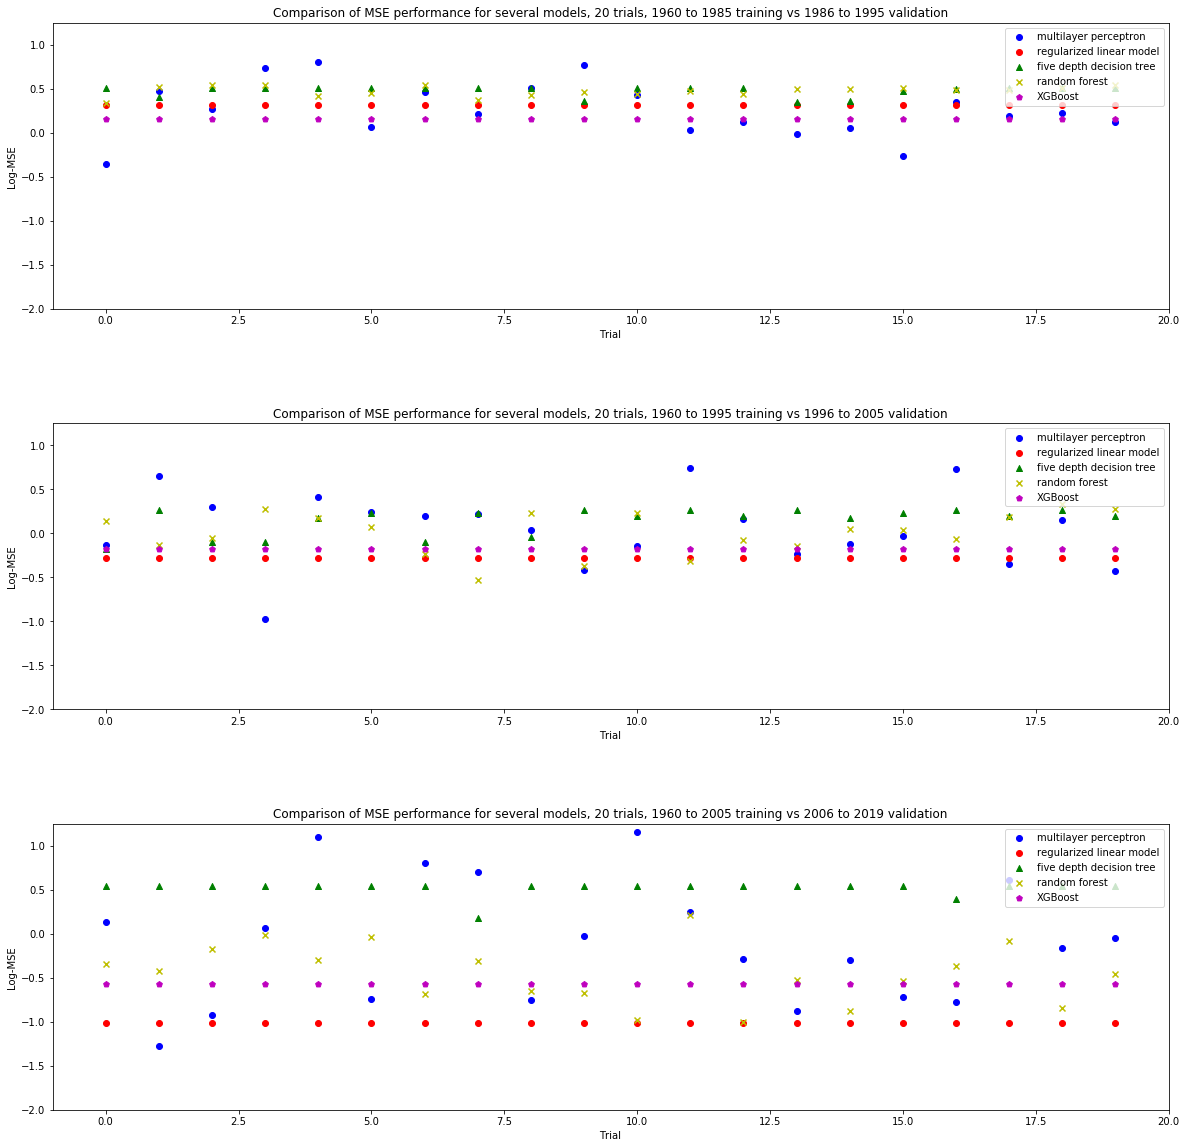

In [13]:
fig, axes = plt.subplots(ncols=1, nrows=3,figsize=(20,20))
fig.subplots_adjust(hspace = 0.4)
plt.setp(axes, xlim=(-1,20),ylim=(-2,1.25))


#First time period
axes[0].title.set_text("Comparison of MSE performance for several models, 20 trials, 1960 to 1985 training vs 1986 to 1995 validation")
axes[0].scatter([i for i in range(20)], [np.log10(j[5]) for j in nestedTesting[0]], c='b', label="multilayer perceptron")
axes[0].scatter([i for i in range(20)], [np.log10(j[2]) for j in nestedTesting[0]], c='r', label="regularized linear model")
axes[0].scatter([i for i in range(20)], [np.log10(j[4]) for j in nestedTesting[0]], c='g', marker = "^", label="five depth decision tree")
axes[0].scatter([i for i in range(20)], [np.log10(j[6]) for j in nestedTesting[0]], c='y', marker = "x", label="random forest")
axes[0].scatter([i for i in range(20)], [np.log10(j[8]) for j in nestedTesting[0]], c='m', marker = "p", label="XGBoost")
axes[0].legend(loc = "upper right")
axes[0].set_xlabel("Trial")
axes[0].set_ylabel("Log-MSE")

#Second time period
axes[1].title.set_text("Comparison of MSE performance for several models, 20 trials, 1960 to 1995 training vs 1996 to 2005 validation")
axes[1].scatter([i for i in range(20)], [np.log10(j[5]) for j in nestedTesting[1]], c='b', label="multilayer perceptron")
axes[1].scatter([i for i in range(20)], [np.log10(j[2]) for j in nestedTesting[1]], c='r', label="regularized linear model")
axes[1].scatter([i for i in range(20)], [np.log10(j[4]) for j in nestedTesting[1]], c='g', marker = "^", label="five depth decision tree")
axes[1].scatter([i for i in range(20)], [np.log10(j[6]) for j in nestedTesting[1]], c='y', marker = "x", label="random forest")
axes[1].scatter([i for i in range(20)], [np.log10(j[8]) for j in nestedTesting[1]], c='m', marker = "p", label="XGBoost")
axes[1].legend(loc = "upper right")
axes[1].set_xlabel("Trial")
axes[1].set_ylabel("Log-MSE")

#Third time period
axes[2].title.set_text("Comparison of MSE performance for several models, 20 trials, 1960 to 2005 training vs 2006 to 2019 validation")
axes[2].scatter([i for i in range(20)], [np.log10(j[5]) for j in nestedTesting[2]], c='b', label="multilayer perceptron")
axes[2].scatter([i for i in range(20)], [np.log10(j[2]) for j in nestedTesting[2]], c='r', label="regularized linear model")
axes[2].scatter([i for i in range(20)], [np.log10(j[4]) for j in nestedTesting[2]], c='g', marker = "^", label="five depth decision tree")
axes[2].scatter([i for i in range(20)], [np.log10(j[6]) for j in nestedTesting[2]], c='y', marker = "x", label="random forest")
axes[2].scatter([i for i in range(20)], [np.log10(j[8]) for j in nestedTesting[2]], c='m', marker = "p", label="XGBoost")
axes[2].legend(loc = "upper right")
axes[2].set_xlabel("Trial")
axes[2].set_ylabel("Log-MSE")

Next we make use of nested validation where the model is exposed to more and more time over several iterations. 

The regularized linear model beats out XGBoost over the second and third tests. XGBoost remains reliably performant, being beaten only ocassionaly by both random forest and the perceptron.

The perceptron's performance varies widly between great (better than linear or XGBoost) and awful (orders of magnitude worse than everything else). Investigation into stabilizing its performance might be worthwhile.

It might also be useful to test the model on periods of time that are separated, to look for more general trends, unconnected to movements of the market.

In [0]:
def disjointedValidation():
  #This function will train a set of model on the beginning and ends of the time period,
  # using respectively the end and beginning of the period as validation data.

  #Each period is tested 20 times
  results1 = []
  results2 = []
  for i in tqdm(range (20)):
    results1.append(testSetOfModels(X_train = merged_df.loc[0:35,"0t4F":"80pM"],
                  X_test = merged_df.loc[49:59,"0t4F":"80pM"],
                  y_train = merged_df.loc[0:35,"yearPctVar"],
                  y_test = merged_df.loc[49:59,"yearPctVar"], verbose=False))
    results2.append(testSetOfModels(X_train = merged_df.loc[25:59,"0t4F":"80pM"],
                  X_test = merged_df.loc[0:10,"0t4F":"80pM"],
                  y_train = merged_df.loc[25:59,"yearPctVar"],
                  y_test = merged_df.loc[0:10,"yearPctVar"], verbose=False))

  return([results1,results2])
  

In [15]:
disjointedTesting = disjointedValidation()

  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[20:12:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
  5%|▌         | 1/20 [00:00<00:08,  2.13it/s]

[20:12:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
 10%|█         | 2/20 [00:00<00:08,  2.06it/s]

[20:12:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:12:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[20:12:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
 15%|█▌        | 3/20 [00:01<00:08,  2.10it/s]

[20:12:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[20:12:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
 20%|██        | 4/20 [00:02<00:08,  1.88it/s]

[20:12:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
 25%|██▌       | 5/20 [00:02<00:08,  1.86it/s]

[20:12:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:12:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
 30%|███       | 6/20 [00:02<00:06,  2.25it/s]

[20:12:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:12:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
 35%|███▌      | 7/20 [00:03<00:05,  2.24it/s]

[20:12:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:12:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
 40%|████      | 8/20 [00:03<00:05,  2.11it/s]

[20:12:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:12:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
 45%|████▌     | 9/20 [00:04<00:05,  2.08it/s]

[20:12:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:12:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[20:12:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
 50%|█████     | 10/20 [00:05<00:05,  1.90it/s]

[20:12:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
 55%|█████▌    | 11/20 [00:05<00:04,  1.99it/s]

[20:12:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:12:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
 60%|██████    | 12/20 [00:05<00:03,  2.11it/s]

[20:12:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:12:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[20:12:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
 65%|██████▌   | 13/20 [00:06<00:04,  1.70it/s]

[20:12:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
 70%|███████   | 14/20 [00:07<00:03,  1.85it/s]

[20:12:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:12:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[20:12:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
 75%|███████▌  | 15/20 [00:07<00:02,  1.95it/s]

[20:12:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[20:12:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
 80%|████████  | 16/20 [00:08<00:02,  1.68it/s]/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[20:12:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:12:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
 85%|████████▌ | 17/20 [00:08<00:01,  2.05it/s]

[20:12:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
 90%|█████████ | 18/20 [00:09<00:01,  2.00it/s]

[20:12:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:12:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
 95%|█████████▌| 19/20 [00:09<00:00,  2.04it/s]

[20:12:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:12:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
100%|██████████| 20/20 [00:09<00:00,  2.40it/s]

[20:12:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:12:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Text(0, 0.5, 'Log 10-MSE')

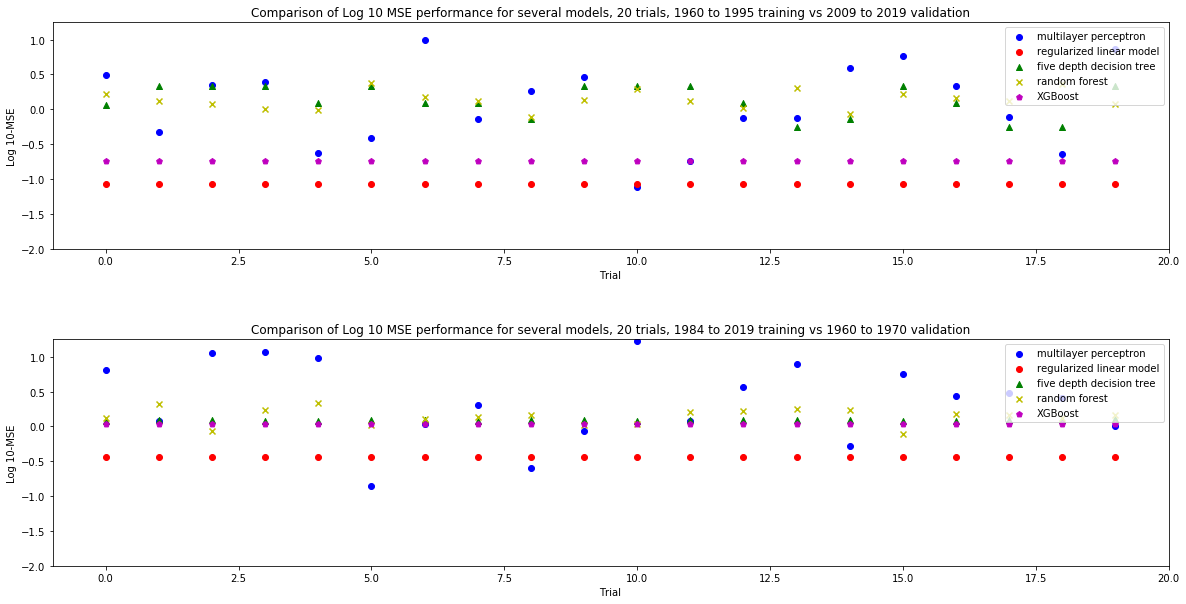

In [16]:
fig, axes = plt.subplots(ncols=1, nrows=2,figsize=(20,10))
fig.subplots_adjust(hspace = 0.4)
plt.setp(axes, xlim=(-1,20),ylim=(-2,1.25))


#First time period
axes[0].title.set_text("Comparison of Log 10 MSE performance for several models, 20 trials, 1960 to 1995 training vs 2009 to 2019 validation")
axes[0].scatter([i for i in range(20)], [np.log10(j[5]) for j in disjointedTesting[0]], c='b', label="multilayer perceptron")
axes[0].scatter([i for i in range(20)], [np.log10(j[2]) for j in disjointedTesting[0]], c='r', label="regularized linear model")
axes[0].scatter([i for i in range(20)], [np.log10(j[4]) for j in disjointedTesting[0]], c='g', marker = "^", label="five depth decision tree")
axes[0].scatter([i for i in range(20)], [np.log10(j[6]) for j in disjointedTesting[0]], c='y', marker = "x", label="random forest")
axes[0].scatter([i for i in range(20)], [np.log10(j[8]) for j in disjointedTesting[0]], c='m', marker = "p", label="XGBoost")
axes[0].legend(loc = "upper right")
axes[0].set_xlabel("Trial")
axes[0].set_ylabel("Log 10-MSE")

#Second time period
axes[1].title.set_text("Comparison of Log 10 MSE performance for several models, 20 trials, 1984 to 2019 training vs 1960 to 1970 validation")
axes[1].scatter([i for i in range(20)], [np.log10(j[5]) for j in disjointedTesting[1]], c='b', label="multilayer perceptron")
axes[1].scatter([i for i in range(20)], [np.log10(j[2]) for j in disjointedTesting[1]], c='r', label="regularized linear model")
axes[1].scatter([i for i in range(20)], [np.log10(j[4]) for j in disjointedTesting[1]], c='g', marker = "^", label="five depth decision tree")
axes[1].scatter([i for i in range(20)], [np.log10(j[6]) for j in disjointedTesting[1]], c='y', marker = "x", label="random forest")
axes[1].scatter([i for i in range(20)], [np.log10(j[8]) for j in disjointedTesting[1]], c='m', marker = "p", label="XGBoost")
axes[1].legend(loc = "upper right")
axes[1].set_xlabel("Trial")
axes[1].set_ylabel("Log 10-MSE")

The first plot sees a model trained in the past try to predict the future. XGBoost performs slightly worse than the regularized linear model.

When trained on data from the end of the dataset, all models take a hit on their accuracy.

It is possible that in these tests where the training data is shrunk even further (35 training points compared to 47 for the inital 80-20 test), XGBoost suffers compared to the regularized linear model.


In [17]:
#Mean calculations
#linear model
print("Front to back mean for linear model:", np.mean([(j[2]) for j in disjointedTesting[1]]))
print("Back to front mean for linear model:",np.mean([(j[2]) for j in disjointedTesting[0]]))
print("***")
#multilayer perceptron
print("Front to back mean for perceptron:", np.mean([(j[5]) for j in disjointedTesting[1]]))
print("Back to front mean for perceptron:",np.mean([(j[5]) for j in disjointedTesting[0]]))
print("***")

#decision tree
print("Front to back mean for decision tree:", np.mean([(j[4]) for j in disjointedTesting[1]]))
print("Back to front mean for decision tree:",np.mean([(j[4]) for j in disjointedTesting[0]]))
print("***")

#Random forest
print("Front to back mean for random forest:", np.mean([(j[6]) for j in disjointedTesting[1]]))
print("Back to front mean for random forest:",np.mean([(j[6]) for j in disjointedTesting[0]]))
print("***")

print("Front to back mean for XGBoost:", np.mean([(j[8]) for j in disjointedTesting[1]]))
print("Back to front mean for XGBoost:",np.mean([(j[8]) for j in disjointedTesting[0]]))
print("***")


Front to back mean for linear model: 0.36005964559430576
Back to front mean for linear model: 0.08361563962206736
***
Front to back mean for perceptron: 4.461098836660791
Back to front mean for perceptron: 2.318080585391251
***
Front to back mean for decision tree: 1.2298866722496637
Back to front mean for decision tree: 1.494514827594716
***
Front to back mean for random forest: 1.434851504081487
Back to front mean for random forest: 1.4333689545337995
***
Front to back mean for XGBoost: 1.0679607192824738
Back to front mean for XGBoost: 0.17876621768282677
***


# Tuning randomforest and XGBoost
On recommendation from a data science mentor, the ensemble and boosted learning methods are investigated further here. 

My idea is that by preventing drastic overfitting the random forest method and xgboost methods can be made much more useful. For the random forest, the maximum number of trees is cut (ah!). As to the XGBoost method, by using early stopping when it ceases to improve on validation data it is hoped that the method will perform much better.

In [18]:
EightyTwenty_X_train = X_train2
EightyTwenty_X_test = X_test2
EightyTwenty_y_train = y_train2
EightyTwenty_y_test = y_test2

model1 = RandomForestRegressor() #Standard random forest with 100 trees
model1.fit(EightyTwenty_X_train,EightyTwenty_y_train)
y_pred1 = model1.predict(EightyTwenty_X_test)
print("Random forest MSE using 100 trees:",mean_squared_error(EightyTwenty_y_test,y_pred1))

model2 = RandomForestRegressor(n_estimators=12) #random forest with 12 trees, or the number of predictors/3 roughly
model2.fit(EightyTwenty_X_train,EightyTwenty_y_train)
y_pred2 = model2.predict(EightyTwenty_X_test)
print("Random forest MSE using 12 trees:",mean_squared_error(EightyTwenty_y_test,y_pred2))





model3 = XGBRegressor()
#0.22 performance with both set of regularization; by default xgbregressor uses ridge
model3.fit(EightyTwenty_X_train,EightyTwenty_y_train)
y_pred3 = model3.predict(EightyTwenty_X_test)
print("Random forest MSE using XGBoost:",mean_squared_error(EightyTwenty_y_test,y_pred3))


model4 = XGBRegressor()
#0.22 performance with both set of regularization; by default xgbregressor uses ridge
model4.fit(EightyTwenty_X_train,EightyTwenty_y_train, early_stopping_rounds = 5, eval_set = [(EightyTwenty_X_test,EightyTwenty_y_test)], eval_metric = "rmse", verbose=True)
y_pred4 = model4.predict(EightyTwenty_X_test)
print("Random forest MSE using XGBoost and early stopping:",mean_squared_error(EightyTwenty_y_test,y_pred4))




Random forest MSE using 100 trees: 0.17773958351269628
Random forest MSE using 12 trees: 0.14115664177107953
[20:12:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Random forest MSE using XGBoost: 0.22969730816261177
[20:12:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.311677
Will train until validation_0-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:0.277025
[2]	validation_0-rmse:0.248476
[3]	validation_0-rmse:0.229022
[4]	validation_0-rmse:0.228551
[5]	validation_0-rmse:0.242289
[6]	validation_0-rmse:0.24973
[7]	validation_0-rmse:0.247667
[8]	validation_0-rmse:0.270817
[9]	validation_0-rmse:0.272011
Stopping. Best iteration:
[4]	validation_0-rmse:0.228551

Random forest MSE using XGBoost and early stopping: 0.05223546550528823


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Early stopping the XGBoost algorthm allows it to be useful on the small dataset.
It has thus been added retroactively to the previous graph.

In [26]:
#Data imports Japan
populationURL = "https://raw.githubusercontent.com/doodger/dataScience/master/f2e7155c-8015-4fa7-acc4-a72350ec0834_Data.csv"
SaP500URL = "https://raw.githubusercontent.com/doodger/dataScience/master/%5EN225.csv"

jap_pop_df = pd.read_csv(populationURL)
nikkei_df = pd.read_csv(SaP500URL)

##Data cleaning and sorting for the population

#Demographics data
#Sorting
jap_pop_df = jap_pop_df.sort_values("Series Code")
jap_pop_df
#superflous row deleted
jap_pop_df = jap_pop_df.drop([27])
jap_pop_df.index = [i for i in range(40)]

jap_pop_df

#Rows 35,36 and 37 are rows of Nan
#Rows 38 and 39 only have a value at the head, detailling the database's World bank origin

print("Total missing value for rows 0 to 34:",jap_pop_df.loc[0:34].isnull().sum().sum())
jap_pop_df = jap_pop_df.loc[0:33] #row 34 is the total population and isn't needed



Total missing value for rows 0 to 34: 0


In [29]:
#Japanese financial data

#Nikkei data
nikkei_df
#print("Total missing value for nikkei data:",nikkei_df.isnull().sum().sum())




,Date,Open,High,Low,Close,Adj Close,Volume
0,1965-01-01,1257.719971,1289.500000,1242.270020,1242.270020,1242.270020,0
1,1965-02-01,1242.829956,1263.589966,1213.069946,1213.069946,1213.069946,0
2,1965-03-01,1206.479980,1213.030029,1132.770020,1132.770020,1132.770020,0
3,1965-04-01,1127.579956,1183.119995,1119.859985,1176.640015,1176.640015,0
4,1965-05-01,1163.510010,1163.869995,1081.510010,1096.599976,1096.599976,0
...,...,...,...,...,...,...,...
643,2018-08-01,22642.179688,23032.169922,21851.320313,22865.150391,22865.150391,1515200
644,2018-09-01,22819.169922,24286.099609,22172.900391,24120.039063,24120.039063,1447600
645,2018-10-01,24173.369141,24448.070313,20971.929688,21920.460938,21920.460938,1822800
646,2018-11-01,21906.410156,22583.429688,21243.380859,22351.060547,22351.060547,1534700


TODO


*   better age pyramid (inverse y axis, positive label instead of negative for women)
*   Monthly volatility into yearly volatility?
*   Price needs to be in % variation I think
*   Should first column of percentage variation be 0 or N/A? look up from previous year?
*   give yearpctvar a proper name without breaking heatmap?
*   Women poorer?
*   Non linear stuff?
*   Scatter plot with color for year + labels + same scale
*   PCA of only population data?
*   K-Cross validation on 10-25 period of years?
*   Volatility adjusted to volume?
*   program sliding and nested cross validation
*   try new models decision trees on it, random forrests, even go for a neural net (multilayer perceptron) in sklearn + Make sure to do some more ML models, like random forest, xgboost (this one for sure), and also definitely a simple decision tree
*   japanese data
*   Grid search for random tree?



Links on the topic
https://medium.com/rants-on-machine-learning/what-to-do-with-small-data-d253254d1a89